In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from transformers import DistilBertTokenizer , DistilBertModel, DistilBertConfig, BertConfig
import torch
import torch.nn as nn
from numba import cuda
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_



from tqdm import tqdm
import pickle


from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/MyDrive/gen proj/new'

Mounted at /gdrive
/gdrive/MyDrive/gen proj/new


In [ ]:
dataset = pd.read_csv('WELFake_Dataset.csv')

In [ ]:
print("Total Training Instances: ", len(dataset))

Total Training Instances:  72134


In [ ]:
dataset.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


label
1    37106
0    35028
Name: count, dtype: int64


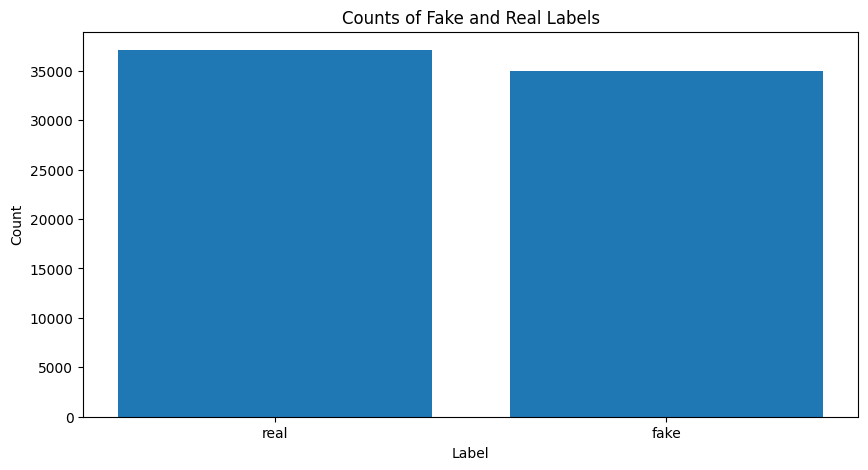

In [ ]:
val_counts = dataset['label'].value_counts()
print(val_counts)
plt.figure(figsize=(10, 5))

# dataset['label'] = dataset['label'].map({0: 'fake', 1: 'real'})

# Count the occurrences of each label
# label_counts = dataset['label'].value_counts()

# Create bar chart
plt.bar(["real", "fake"], val_counts.values)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of Fake and Real Labels')

# Show plot
plt.show()

In [ ]:
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
dataset = dataset[dataset['text'].notna()]
len(dataset)

72095

In [ ]:
data = dataset[['title','text','label']]
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
import re

In [ ]:
data.dropna(subset=['label'], inplace=True)
data['label'] = data['label'].replace({'Real': 1, 'Fake': 0})
data['label'] = data['label'].astype(int)

In [ ]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',str(text))

data['text'] = data['text'].apply(remove_url)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',str(text))

data['text'] = data['text'].apply(remove_html)

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', str(text)) # no emoji

data['text'] = data['text'].apply(remove_emoji)

In [ ]:
def processing(df):
    df = df.fillna('No info', axis=1)
    df['text'] = df.title  + df.text
    return df

data = processing(data)

In [ ]:
x = list(data['text'])
y = list(data['label'])


In [ ]:
print(data.loc[:, :].isnull().sum())

title    0
text     0
label    0
dtype: int64


In [ ]:

# If you need a reproducible result, you can add a 'random_state'
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Creating a PyTorch tensor dataset

The following function is defined to make a PyTorch tensor dataset. The parameter given to the function are `X` which represents the comments to be classified, `y` containing the gold labels for the comments, and a `tokenizer`. The tokenizer we are using is Distil Bert Tokenizer and we are using pretrained format by using the model we got from the `Hugging Face Transformers` library.

In the for loop, we are encoding the dataset using the tokenizer. THe maximum length is 512 and if a sentence is less than that, it is padded to 512 and if it more than 512, it is truncated. The encoded_dict return the input_ids and attention mask.

The `input_ids` is a list that stores the tokenized and encoded input_ids. The `attention_mask` is a binary mask that indicates which tokens in the input sequence are actual tokens and which are padding tokens. It is used so that during training the padding tokens can be ignored.

The next for loop is converting the labels to a pyTorch float type tensor.

Next we are stacking each list to be able to make the dataset

Lastly, using these stacked `input ids`, `attention masks` and these `label` tensors we are creating the tensor dataset using the inbuilt `TensorDataset` and returning this dataset.

In [ ]:
def get_TensorDataset(X,y, tokenizer):

    input_ids = []
    attention_mask = []
    y_tensor = []


    X = X
    y = y

    # for text in X:
        # print(text)
    tokenized_data = tokenizer(
        X,
        max_length=512,          # Pad or truncate all sentences to the same length
        truncation=True,         # Explicitly ask to truncate longer sequences
        padding=True,    # Pad shorter sequences
        return_tensors='pt'      # Return PyTorch tensors
    )
    # input_ids.append(torch.tensor(encoded_dict['input_ids'][0]))
    # attention_mask.append(torch.tensor(encoded_dict['attention_mask'][0]))

    y_tensor = torch.tensor(list(y), dtype=torch.long)


    # input_ids_tensor = torch.stack(input_ids)
    # attention_mask_tensor = torch.stack(attention_mask)
    # y_tensor = torch.stack(y_tensor)

    tensor = TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'], y_tensor)

    return tensor


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:

# y_train = torch.tensor(list(y_train), dtype=torch.long)
# y_val = torch.tensor(list(y_val), dtype=torch.long)

# train_tensor = get_TensorDataset(X_train, y_train, tokenizer=tokenizer)
# val_tensor = get_TensorDataset(X_val, y_val, tokenizer=tokenizer)


# # # with open('test_tensor_new.pkl', 'wb') as file:
# # #     pickle.dump(test_tensor, file)




KeyboardInterrupt: 

## Getting the Evaluation Metrics

The functions in the next few cells are used to get the accuracy, precision, recall, and confusion matrix for our model. We are using the `sklearn.metrics` module to get these scores.

For `accuracy`, first we are applying sigmoid function to convert our logits to prediction of 0 or 1 (as they are reprsented in the dataset). Then we are calculating the accuracy for each class separately. Finally, we are calculating the overall accuracy (only where all labels are correct) by calculating the number of times predicted labels have matched the true labels and then taking its mean.

For `precision`, `recall`, and `f1` everything is the same as accuracy except the calculation of micro precision, micro recall, and micro f1 for which we are using the in-built 'micro' parameter of precision_score and recall_score and f1_score (this was not available for accuracy).

For `confusion matrix` we are making the confusion matrix of each individual class.

Finally, we have a function of `heat_map` to make the confusion matrix and a function to get the overall evaluation scores for our model.

In [3]:
def get_Accuracy(y_true,y_pred):
    # Apply sigmoid to logits and convert to binary predictions (0 or 1)
    y_true = np.array(y_true)
    # y_pred = y_pred.detach().cpu().numpy()
    preds = y_pred
    # print(np.shape(preds), np.shape(y_true),np.shape(y_pred))
    preds = np.array(preds)

    exact_match = np.sum(preds == y_true)
    # print("exact match: ", exact_match)
    # exact_match = (preds == y_true).all(dim=1
    overall_acc = exact_match / len(y_true)
    # print(overall_acc)
    return {
        'overall': overall_acc
    }

In [4]:
def get_Prec(y_true , y_pred):
    y_true = np.array(y_true)
    # y_pred = y_pred.detach().cpu().numpy()
    preds = y_pred


    overall_prec = precision_score(y_true, preds, average='micro')


    return {
        'overall': overall_prec
    }

In [5]:
def get_Recall(y_true , y_pred, threshold):
    y_true = np.array(y_true)
    # y_pred = y_pred.detach().cpu().numpy()
    preds = y_pred


    overall_recall = recall_score(y_true, preds, average='micro')


    return {
        'overall': overall_recall
    }

In [6]:
def get_f1(y_true,y_pred,threshold):
    # Apply sigmoid to logits and convert to binary predictions (0 or 1)
    y_true = np.array(y_true)
    # y_pred = y_pred.detach().cpu().numpy()
    preds = y_pred
    # print(preds)
    # preds = preds.type_as(y_true)

    micro_f1 = f1_score(y_true, preds, average='micro')
    # exact_match = (preds == y_true).all(dim=1)
    # overall_f1 = exact_match.float().mean().item()
    # print(overall_acc)
    return {
        'overall': micro_f1
    }

In [7]:
def get_Confusion_Matrices(y_true , y_pred, threshold):
    y_true = np.array(y_true)
    # y_pred = y_pred.detach().cpu().numpy()
    preds = y_pred

    # preds = preds.type_as(y_true)

    cf = confusion_matrix(y_true,preds)




    return {
        'cf': cf,
    }

In [8]:
def make_heat_map(cf,label):
    plt.figure(figsize=(8,4))
    sns.heatmap(cf,xticklabels=[label,f'Not {label}'], yticklabels = [label,f'Not {label}'], annot = True, cmap="cividis")
    plt.title(f'Model\'s Confusion matrix for {label} comments')
    plt.xlabel("Gold Labels")
    plt.ylabel("Model Predictions")
    plt.show()

In [9]:
def  overall_eval(y_true , y_pred, threshold):
    accuracy = get_Accuracy(y_true,y_pred,threshold)
    precision = get_Prec(y_true,y_pred,threshold)
    recall = get_Recall(y_true,y_pred,threshold)
    f1 = get_f1(y_true,y_pred,threshold)
    cf = get_Confusion_Matrices(y_true,y_pred,threshold)

    # all_labels =  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

    print("\n Overall Stats: \n")
    print("accuracy: ", accuracy['overall'])
    print(" Micro precision : ", precision['overall'])
    print(" Micro recall: ", recall['overall'])
    print(" Micro F1: ", f1['overall'])
    print('\n----------------------------------------------------------------------------------------------------------------------------------\n')
    make_heat_map(cf['cf'])


Loading the pretrained weights for the `DistilBertTokenizer`

`get_TensorDataset` funciton called to convert train and val data into TensorDataset format

### Creating batches from our tensor dataset

Using the DataLoader module imported above to make the dataset in batches, and easier to use, of our data of the specified `batch_size`. A batch_size of `64` is chosen for faster performance.

In [10]:
from torch.utils.data import Subset
# Load the TensorDataset from the pickle file
with open('train_tensor_new.pkl', 'rb') as file:
    train_tensor = pickle.load(file)

with open('val_tensor_new.pkl', 'rb') as file:
    val_tensor = pickle.load(file)

batch_size = 64


train_dataloader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Initializing the parameters for our model

The following line of code represents the parameters that we are using for our model. `num_labels` represents the number of labels present in our dataset. The other parameters were chosen after going through multiple online resources

### Making the model class
The following class represents our model. We are using the `DistilBertModel` using pre-trained weights from 'distilbert-base-uncased'.
Then there is a `pre_classifier linear layer` that has the same input and output size which is equal to the hidden_size.
Next there is the `dropout layer` which is used to prevent overfitting.
Lastly, there is the `classifier linear layer` for which the input size is equal to hidden_size which is projected to the output size (equal to the number of labels that is 6).

After defining these layers, there is the `forward` pass function that takes the input_ids and attention_mask as parameters. It then passes them through the DistilBertModel which gives the output in the form of a tuple where out[0] represents the hidden_state of that layer.
Next line extracts the representation of the first token (CLS token) from the hidden states. This is often used as a pooled representation of the entire sequence.
After that, a linear transformation is applied to this pooled representation using pre_classifier. Next, the `ReLU` activation function is applied to the ouput of the linear transformation. Then, dropout is applied to the output of the activation function. Finally, we get the final logits by applying the classifier linear layer to the output of dropout.

### Initializing the model
- loss = BCEWithLogitsLoss
- optimizer = Adam, lr = 0.00003
- epochs = 2
- scheduler

In [12]:
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2, num_hidden_layers=12, hidden_size=768, output_attentions=True)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {'params': model.bert.parameters(), 'lr': 5e-5},
    {'params': model.classifier.parameters(), 'lr': 5e-5}
], lr=5e-5)

epochs = 1


scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation function which is then called below to perform the validation. In training function, we evaluate validation data after each epoch and print all the stats of training dataset of the epoch and validation

In [13]:
from torch.nn.utils import clip_grad_norm_


In [14]:
def validate(model,criterion):
    model.eval()
    val_accuracy = 0
    val_loss = 0
    for _,batch in tqdm(enumerate(val_dataloader)):
        input_ids, mask, true_labels = batch
        input_ids, mask, true_labels = input_ids.to(device), mask.to(device), true_labels.to(device)
        # true_labels = true_labels.unsqueeze(1)
        with torch.no_grad():
          out_logits = model(input_ids, attention_mask=mask, labels=true_labels)
        loss = out_logits.loss
        val_loss += loss.item()
        logits = out_logits.logits
        preds = torch.argmax(logits, dim=1)
        accuracy = get_Accuracy(true_labels, preds)
        # accuracy = get_Accuracy(true_labels,logits,0.4)
        val_accuracy +=  accuracy['overall']
    return val_accuracy/len(val_dataloader) , val_loss/len(val_dataloader)

### Training the model
- model trained for epochs defined above
- validation and stats after each epoch
- overall results give good stats

In [15]:
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

In [16]:
def model_train(epochs, model, optimizer,criterion,scheduler):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        train_accuracy = 0
        val_accuracy = 0
        model.train()
        for _,data in tqdm(enumerate(train_dataloader)):
            input_ids, mask, true_labels = data
            input_ids, mask, true_labels = input_ids.to(device), mask.to(device), true_labels.to(device)
        # true_labels = true_labels.unsqueeze(1)
            # true_labels = true_labels.unsqueeze(1)

            optimizer.zero_grad()
            # print("here")
            out_logits = model(input_ids=input_ids, attention_mask=mask, labels=true_labels)
            # print(logits)true_labels
            # print('\n\n\n\n')
            # print(true_labels)
            # print("here")
            loss = out_logits.loss
            # print("here")
            train_loss += loss.item()
            loss.backward()

            logits = out_logits.logits
            preds = torch.argmax(logits, dim=1)
            # print(true_labels,'\n\n\n\n\n\n')
            # print(preds)
            accuracy = get_Accuracy(true_labels, preds)
            train_accuracy += accuracy['overall']

            if _%40==0:
                print(f'Epoch: {epoch},Batch {_}, Loss:  {loss.item()}, Accuracy: {train_accuracy/(_+1)}')
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        scheduler.step()
        train_losses.append(train_loss/(len(train_dataloader)))
        train_accuracies.append(train_accuracy/(len(train_dataloader)))
        val_accuracy,val_loss = validate(model, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch: {epoch}, Train Loss:  {train_loss/(len(train_dataloader))}, Train Accuracy: {train_accuracy/(len(train_dataloader))},  Val Loss:  {val_loss}, Val Accuracy: {val_accuracy}')



model_train(epochs,model,optimizer,criterion,scheduler)

0it [00:00, ?it/s]

Epoch: 0,Batch 0, Loss:  0.6749188303947449, Accuracy: 0.53125


41it [23:03, 33.68s/it]

Epoch: 0,Batch 40, Loss:  0.11127965897321701, Accuracy: 0.9054878048780488


81it [45:54, 34.47s/it]

Epoch: 0,Batch 80, Loss:  0.057729922235012054, Accuracy: 0.9390432098765432


120it [1:08:21, 34.52s/it]

Epoch: 0,Batch 120, Loss:  0.07365534454584122, Accuracy: 0.952995867768595


160it [1:31:32, 34.83s/it]

Epoch: 0,Batch 160, Loss:  0.01288165058940649, Accuracy: 0.9586568322981367


201it [1:55:18, 34.77s/it]

Epoch: 0,Batch 200, Loss:  0.03655082732439041, Accuracy: 0.9636194029850746


240it [2:18:00, 34.60s/it]

Epoch: 0,Batch 240, Loss:  0.12467604130506516, Accuracy: 0.9677126556016598


281it [2:41:57, 34.96s/it]

Epoch: 0,Batch 280, Loss:  0.018099283799529076, Accuracy: 0.970807384341637


321it [3:05:17, 34.81s/it]

Epoch: 0,Batch 320, Loss:  0.00726468488574028, Accuracy: 0.9730334890965732


361it [3:28:35, 34.82s/it]

Epoch: 0,Batch 360, Loss:  0.04665599390864372, Accuracy: 0.9745931440443213


401it [3:51:58, 34.98s/it]

Epoch: 0,Batch 400, Loss:  0.04563530534505844, Accuracy: 0.9762312967581047


440it [4:14:57, 35.32s/it]

Epoch: 0,Batch 440, Loss:  0.001437528058886528, Accuracy: 0.9770408163265306


480it [4:38:28, 35.26s/it]

Epoch: 0,Batch 480, Loss:  0.005015000235289335, Accuracy: 0.9783653846153846


520it [5:01:57, 35.26s/it]

Epoch: 0,Batch 520, Loss:  0.000685609586071223, Accuracy: 0.979186660268714


560it [5:25:28, 35.27s/it]

Epoch: 0,Batch 560, Loss:  0.01091718953102827, Accuracy: 0.9798629679144385


601it [5:50:07, 36.50s/it]

Epoch: 0,Batch 600, Loss:  0.01198764331638813, Accuracy: 0.9806052412645591


641it [6:14:27, 36.41s/it]

Epoch: 0,Batch 640, Loss:  0.014436366967856884, Accuracy: 0.9813036271450858


680it [6:38:16, 36.63s/it]

Epoch: 0,Batch 680, Loss:  0.016096901148557663, Accuracy: 0.9818970264317181


720it [7:02:42, 36.63s/it]

Epoch: 0,Batch 720, Loss:  0.0025363413151353598, Accuracy: 0.9824679264909847


721it [7:03:16, 35.22s/it]
181it [40:04, 13.28s/it]


Epoch: 0, Train Loss:  0.050541392715181835, Train Accuracy: 0.9824679264909847,  Val Loss:  0.016999408614613343, Val Accuracy: 0.9948204419889503


### Preparing the test dataset and converting to TensorDataset form using `get_TensorDataset`

In [18]:
tokenizer.save_pretrained('tokenzier')


NameError: name 'tokenizer' is not defined

In [17]:
import torch

# Assuming 'optimizer' is your optimizer instance and 'model' is your BERT model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_1epoch.pth')


In [ ]:
# test_data['labels'] = test_data.iloc[:,2 :].values.tolist()
# test_data.drop(test_data.columns.values[2:-1].tolist(), inplace=True, axis=1)

# print(test_data)
# test_data = test_data.sample(n=2000, random_state=42)

# X_test = test_data['comment_text']
# y_test = test_data['labels']

# test_tensor = get_TensorDataset(X_test,y_test,tokenizer)
# # random_test = random.sample(range(len(test_tensor)), 100)


# test_tensor = Subset(test_tensor, random_train)

<ipython-input-219-dca0a28f34fb>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids.append(torch.tensor(encoded_dict['input_ids'][0]))
<ipython-input-219-dca0a28f34fb>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask.append(torch.tensor(encoded_dict['attention_mask'][0]))


In [ ]:
# with open('test_tensor.pkl', 'wb') as file:
#     pickle.dump(test_tensor, file)

In [ ]:
with open('test_tensor_new.pkl', 'rb') as file:
    test_tensor = pickle.load(file)

### Converting to Dataloader format for 80 batched size

In [ ]:
# random_test= random.sample(range(len(test_tensor)), 5000)

# test_tensor = Subset(test_tensor, random_test)
test_dataloader = DataLoader(test_tensor, batch_size=80, shuffle=True)


### Testing

In [ ]:
all_pred = []
all_true_labels = []
model.eval()
with torch.inference_mode():
  for _, data in tqdm(enumerate(test_dataloader)):
           input_ids = data[0].to(device, dtype = torch.long)
           mask = data[1].to(device, dtype = torch.long)
           true_labels  = data[2].to(device, dtype = torch.float)
           all_true_labels.append(true_labels)
          #  print(np.shape(all_true_labels))
           with torch.no_grad():
            logits = model(input_ids,mask).view(-1,6)
            # probs = torch.sigmoid(logits) > 0.4
           all_pred.append(logits)




25it [03:19,  8.00s/it]


In [ ]:
allll_true = []
for i in all_true_labels:
  for j in i:
    temp = []
    for k in j:
      temp.append(k.item())
    allll_true.append(temp)
allll_true = torch.tensor(allll_true)

In [ ]:
all_pred = torch.cat(all_pred, dim=0)


### Test Stats
- Overall accuracy is good
- low precision due to imbalanced dataset as some labels existed in way too low numbers
- good recall
- overall f1 is fine, its is slighty low due to low precision

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Overall Stats: 

accuracy:  0.8545
 Micro precision :  0.5155615696887687
 Micro recall:  0.774390243902439
 Micro F1:  0.619008935824533

----------------------------------------------------------------------------------------------------------------------------------


 TOXIC
accuracy:  0.9015
 Micro precision :  0.5057803468208093
 Micro recall:  0.8706467661691543
 Micro f1:  0.6398537477148081




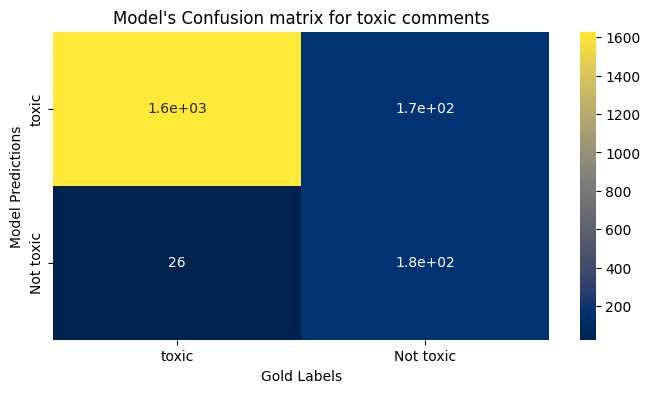


----------------------------------------------------------------------------------------------------------------------------------


 SEVERE_TOXIC
accuracy:  0.9935
 Micro precision :  0.0
 Micro recall:  0.0
 Micro f1:  0.0




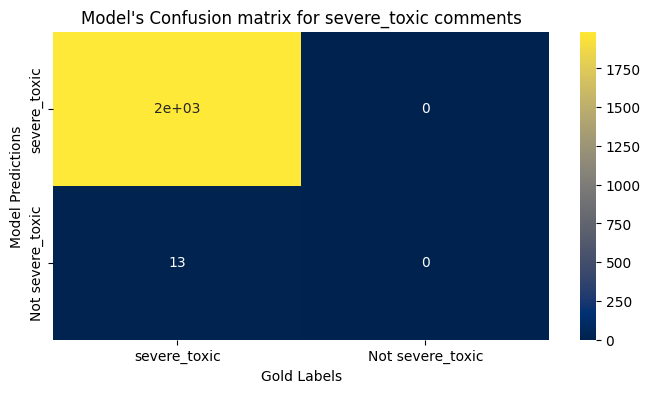


----------------------------------------------------------------------------------------------------------------------------------


 OBSCENE
accuracy:  0.946
 Micro precision :  0.5369458128078818
 Micro recall:  0.8861788617886179
 Micro f1:  0.6687116564417179




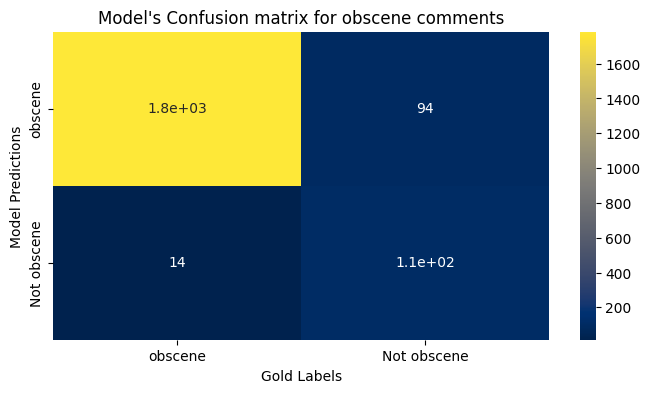


----------------------------------------------------------------------------------------------------------------------------------


 THREAT
accuracy:  0.9965
 Micro precision :  0.0
 Micro recall:  0.0
 Micro f1:  0.0




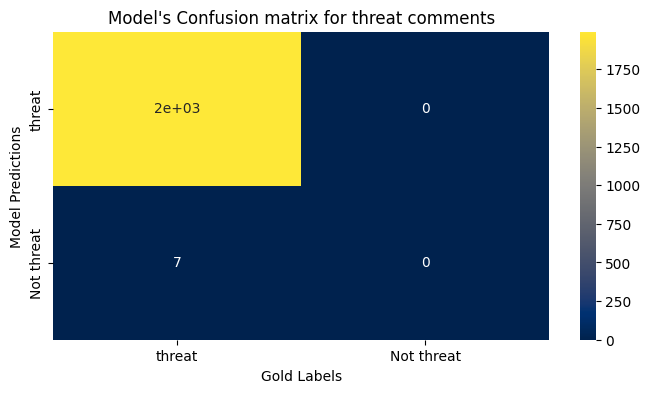


----------------------------------------------------------------------------------------------------------------------------------


 INSULT
accuracy:  0.9415
 Micro precision :  0.5105263157894737
 Micro recall:  0.8016528925619835
 Micro f1:  0.6237942122186495




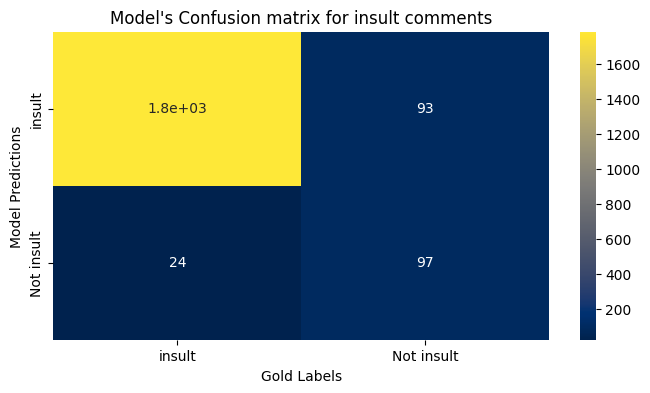


----------------------------------------------------------------------------------------------------------------------------------


 IDENTITY_HATE
accuracy:  0.9865
 Micro precision :  0.0
 Micro recall:  0.0
 Micro f1:  0.0




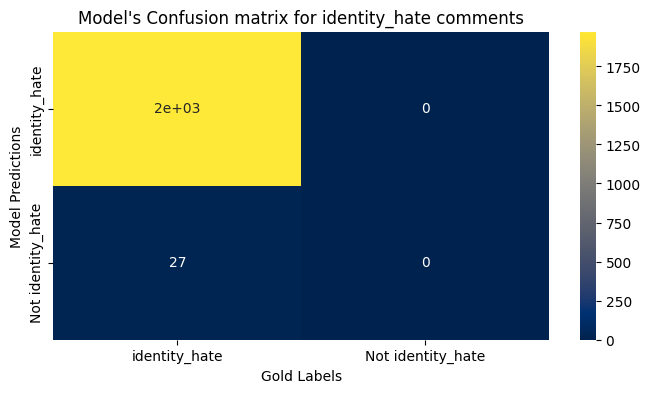


----------------------------------------------------------------------------------------------------------------------------------



In [ ]:
overall_eval(allll_true, all_pred,0.4)